# Misinformation Detection
### Data Visualisation Notebook

*Session 20 Group 4*
*Erica, Sahan, Dinuka*


Imports:

In [13]:
import pandas as pd
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

Reading in data:

In [14]:
dataset = pd.read_excel("data/Constraint_English_Train.xlsx", index_col=0)

dataset.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


Remove empty values

In [15]:
print(f"Before culling: {dataset.size}")
dataset = dataset.replace('', np.nan)
dataset = dataset.dropna()
print(f"After culling: {dataset.size}")

Before culling: 12840
After culling: 12840


No empty values it seems, so continue with visualisation

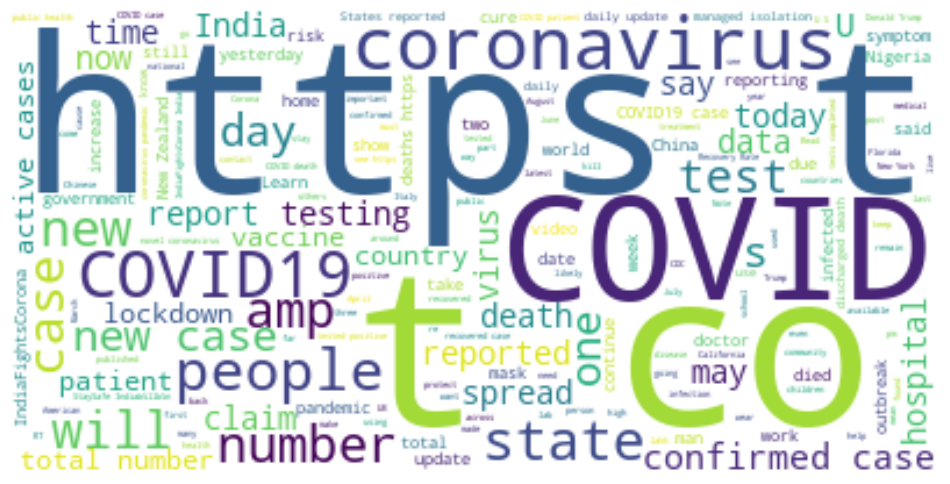

In [9]:
# Generate a wordcloud
text = " ".join(content for content in dataset.tweet)
wordcloud = WordCloud(background_color="white").generate(text)

# Display it
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We need to get rid of words like "http", "t", "co", etc. We can remove this alongside standard stopwords ("and", "or", "in", etc.). "amp" refers to google amp links mostly but we will keep it since someone may be using the word as its standard definition

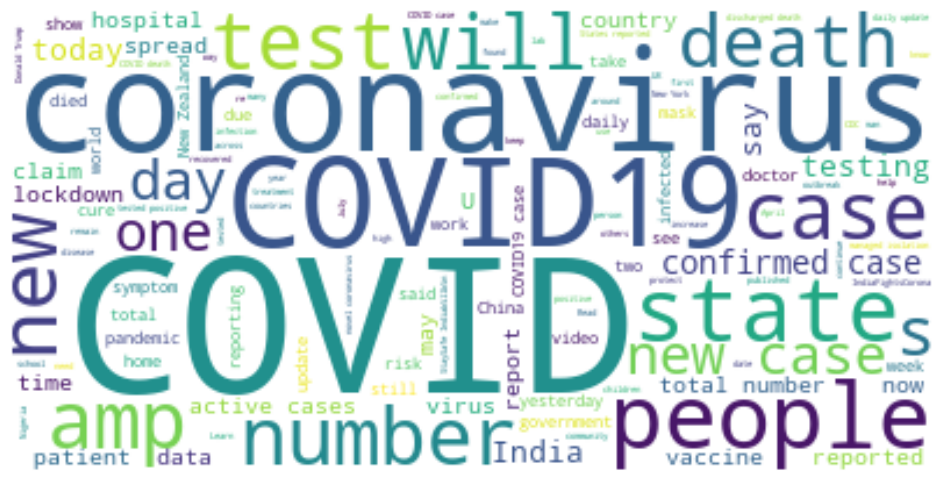

In [11]:
stopwords = set(STOPWORDS)
stopwords.update(["http", "https", "t", "co"])

wordcloud = WordCloud(background_color="white", stopwords=stopwords).generate(text)

# Display our Word Cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Viewing statistics about data

6.4
4.8


<Axes: ylabel='count'>

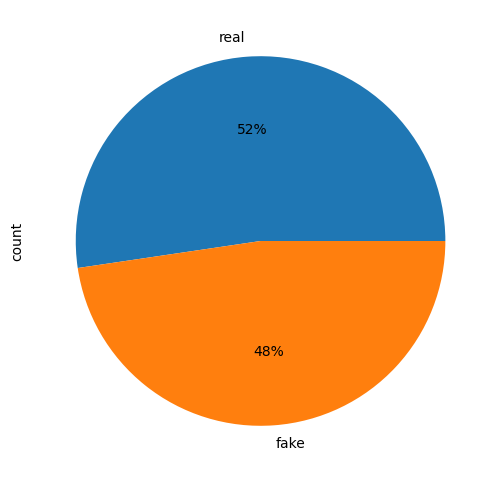

In [12]:
# Plot pie chart showing the split beyween real and fake
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

dataset.label.value_counts().plot(kind='pie', autopct='%1.0f%%')